### Spring 2025 ECG Analysis 

##### Modification: switched from rapidHRV to Systole for heart rate preprocessing & peak detection

In [39]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from scipy.stats import sem
from copy import copy as copy
import operator as operator

import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob

from scipy.signal import find_peaks

from scipy.signal import butter, filtfilt, find_peaks

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_48491/1149338489.py:13: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr # Pearson's correlation
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['pylab', 'time', 'copy', 'show']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [7]:
import pathlib
from ecgdetectors import Detectors
import sys
sampleRate = 100
fs = sampleRate
detectors = Detectors(sampleRate)


In [8]:
mergedDFClean = pd.read_csv("mergedPhysioAndBehav_Jan2025.csv")
# remove Unamed columns
mergedDFClean = mergedDFClean.loc[:, ~mergedDFClean.columns.str.contains('^Unnamed')]
mergedDFClean = mergedDFClean.dropna()

In [9]:
mergedDFClean

,PART_x,EKG,EDA,startBlock,startTrial,infoChoice,stimInfo,stimNoInfo,scream,noScream,...,delaysRaw,session,partNum,PART_y,delay_time,choice_keys,prob,screamOn,infoOn,filename
0,P044_Aversive,-0.126495,3.59192,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
1,P044_Aversive,-0.215912,3.59039,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
2,P044_Aversive,-0.307312,3.59192,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
3,P044_Aversive,-0.311432,3.59039,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
4,P044_Aversive,-0.287170,3.59192,0,1,0,0,0,0,0,...,20.01,0,44,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12708414,P132_Aversive,-0.005310,4.98199,0,0,0,0,0,0,0,...,9.97,5,132,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...
12708415,P132_Aversive,-0.020203,4.98810,0,0,0,0,0,0,0,...,9.97,5,132,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...
12708416,P132_Aversive,-0.015320,4.98352,0,0,0,0,0,0,0,...,9.97,5,132,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...
12708417,P132_Aversive,-0.010315,4.98199,0,0,0,0,0,0,0,...,9.97,5,132,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...


# separate signal by participant

# Estimate Baseline based on beginning of the trial

In [10]:
#preprocess data using Systole
from systole.plots import plot_raw
from systole.detection import ecg_peaks
from systole.plots import plot_subspaces, plot_frequency, plot_poincare
from systole import import_dataset1

from bokeh.io import output_notebook, show

from bokeh.layouts import row


from bokeh.plotting import show

from systole import  import_ppg

### Try with Scipy.signal, preprocess data with bandpass

In [43]:
#scipy signal test
#gonna try to use signal for signal processing and see if it works



def preprocess(delaydata):
    sfreq = 100

    # 5-25Hz 2nd-order bandpass 
    b,a = butter(2, [5/(sfreq/2), 25/(sfreq/2)],btype ='band') 
    
    delayProcessed = pd.DataFrame()
    for participant in np.unique(delaydata['partNum']):
        dataPart = delaydata.loc[delaydata['partNum']==participant].copy()
        my_data = dataPart.EKG.values

        filtered_data = filtfilt(b,a,my_data)

        #signal: 1D numpy array, resampled signal to 1000Hz (default for Systole functions)
        #Peak: 1D array, peaks vector, same size as the input signal, boolean array
        #signal_new, peaks_new = ecg_peaks(my_data, method='pan-tompkins',sfreq=1000)

        peak_idxs, props = find_peaks(
            filtered_data,
            distance=int(0.4*sfreq),       # and with at least 0.3 mV prominence
            prominence = 0.3
        )

        # convert to boolean mask
        peaks = np.zeros_like(filtered_data, dtype=bool)
        peaks[peak_idxs] = True
        dataPart['pEKG'] = filtered_data
        dataPart['peak'] = peaks
        delayProcessed = pd.concat([delayProcessed, dataPart])



    return delayProcessed

In [12]:
### returns all IBI by delay time
def stimInfo_IBI(data):
    
    data['peaks'] = [0]*len(data)
    test_IBI_by_delay = {}

    for trials in data['PART_trial'].unique():
        trial_data = data[data['PART_trial']==trials]
        r_peaks = detectors.two_average_detector(trial_data['pEKG'].values)
        trial_data = trial_data.reset_index()
        trial_data.loc[trial_data.index.isin(r_peaks), 'peaks'] = 1

        peaks_data = trial_data[trial_data['peaks']==1]

        # extract time point stimInfo is presented
        infoStimOnset = trial_data.loc[trial_data['stimInfoOnset'] == 1, 'time'].values
        if(len(infoStimOnset)>1):
            infoStimOnset = infoStimOnset[0]

        # Mark test_IBI values before and after infoStimOnset
        before_stim = []
        after_stim = []
        baseline_data = baseline_IBI[baseline_IBI['PART_trial'] == trials]['baseline'].values
        
        for time in peaks_data['time']:
            if time < infoStimOnset:
                before_stim.append(peaks_data.loc[peaks_data['time']==time,'time'])
            else:
                after_stim.append(peaks_data.loc[peaks_data['time']==time,'time'])
        
        before_IBI = np.diff(np.ravel(np.array([entry for entry in before_stim])))
        before_IBI = [val - baseline_data for val in before_IBI]
        
        
        after_IBI = np.diff(np.ravel(np.array([entry for entry in after_stim])))
        after_IBI = [val - baseline_data for val in after_IBI]

        # concatenate before_stim, mark, and after_stim
        mark = ['mark']
        test_IBI = before_IBI + mark + after_IBI

        delay_time = trial_data['delays'].unique()[0]
        if delay_time not in test_IBI_by_delay:
            test_IBI_by_delay[delay_time] = {}

        # If there are no values after infoStimOnset, set flag to False
        flag = bool(after_stim)

        # add infoStimOnset, test_IBI, and the marked values to test_IBI_by_delay
        test_IBI_by_delay[delay_time][trials] = {
            'before_IBI': before_IBI,
            'after_IBI': after_IBI,
        }

    return test_IBI_by_delay



In [13]:
#calculate average IBI for each delay and returns final IBI + error bar to be plotted

def stimInfo_avgIBI(data):
    average_values_before_list = []
    #standard_error_before_list = []
    average_values_after_list = []
    standard_error_list = []

    for delay_time in data:
        # Access the trial data for the current delay time
        delay_data = data[delay_time]        
        
        min_length_before = max(2,min(len(delay_data[part_trial]['before_IBI']) for part_trial in delay_data.keys()))
        min_length_after = max(2,min(len(delay_data[part_trial]['after_IBI']) for part_trial in delay_data.keys()))
        
        # Calculate the average value in each position
        average_values_before = np.zeros(min_length_before)
        average_values_after = np.zeros(min_length_after)
        
        num_nonempty_arrays_before = 0  # Counter for non-empty arrays
        num_nonempty_arrays_after = 0
        
        values_list = []

        for part_trial in delay_data:
            values_before = np.array(delay_data[part_trial]['before_IBI'][:min_length_before], dtype='float64')
            values_before = np.ndarray.flatten(values_before)
            values_after = np.array(delay_data[part_trial]['after_IBI'][:min_length_after], dtype='float64')
            values_after = np.ndarray.flatten(values_after)
            
            
            values = np.concatenate((values_before,values_after))
            values = np.ndarray.flatten(values)
            values_list.append(values)
            
            # Skip if the array is empty
            if len(values_before) == 0 or len(values_after) == 0:
                continue

            average_values_before += values_before
            num_nonempty_arrays_before +=1
            average_values_after += values_after
            num_nonempty_arrays_after += 1
    
        values_size = max(len(array) for array in values_list)
    
        for i in range(len(values_list)):
            if len(values_list[i]) != values_size:
                num = values_size-len(values_list[i])
                values_list[i] = np.append(values_list[i],[np.nan]*num)

    
        # Calculate the mean and standard error only if there are non-empty arrays
        if num_nonempty_arrays_before > 0:
            average_values_before /= num_nonempty_arrays_before
            #standard_error_before = sem(average_values_before)
        #else:
            #standard_error_before = np.nan

        average_values_before_list.append(average_values_before)
        #standard_error_before_list.append(standard_error_before)
        
        if num_nonempty_arrays_after > 0:
            average_values_after /= num_nonempty_arrays_after
            average_values_after_list.append(average_values_after)
            #standard_error_after = sem(average_values_after)
        #else:
            #standard_error_after = np.nan
        ''' 
        #combine before and after to calculate standard error
    
        average_values = np.concatenate((average_values_before,average_values_after))
        if  num_nonempty_arrays_before+num_nonempty_arrays_after>0:
            standard_error = sem(average_values)
        else:
            standard_error = np.nan

        
        standard_error_list.append(standard_error)
    '''
    
    #********#*#*#***************#calcualte standard error 
        transposed_arrays = np.array(values_list).T

        standard_errors = []

        # Calculate the standard error for each entry
        for entry in transposed_arrays:
            std_error = scipy.stats.sem(entry, nan_policy='omit')
            standard_errors.append(std_error)
        standard_error_list.append(standard_errors)

    #********#*#*#***************#
        
    average_values_df = pd.DataFrame({
        'Delay Time': data.keys(),
        'Average Values Before': average_values_before_list,
        #'Standard Error Before': standard_error_before_list,
        'Average Values After': average_values_after_list,
        'Standard Error': standard_error_list,
        #'stimInfoOnset' : sti
    })

    return average_values_df


In [14]:
def plot_whole_IBI(info_scream_IBI,info_noScream_IBI,delay):
    

    scream_before = info_scream_IBI.loc[info_scream_IBI['Delay Time'] == delay, 'Average Values Before']
    scream_before.index = [0]
    scream_after = info_scream_IBI.loc[info_scream_IBI['Delay Time'] == delay, 'Average Values After']
    scream_after.index = [0]


    noScream_before = info_noScream_IBI.loc[info_noScream_IBI['Delay Time'] == delay, 'Average Values Before']
    noScream_before.index = [0]

    noScream_after = info_noScream_IBI.loc[info_noScream_IBI['Delay Time'] == delay, 'Average Values After']
    noScream_after.index = [0]



    # Concatenate the "before" and "after" values into a single array
    combined_noScream = np.concatenate([np.concatenate(noScream_before), np.concatenate(noScream_after)])
    combined_scream = np.concatenate([np.concatenate(scream_before), np.concatenate(scream_after)])

    # Plotting
    #fig, ax = plt.subplots()
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1)



    # Plot the combined values as a single line
    #plt.plot(combined_scream, label='info scream')
    #plt.plot(combined_noScream, label='info no scream')


    # Calculate the index where the "after" values start
    noScream_after_start_index = len(noScream_before[0])
    scream_after_start_index = len(scream_before[0])
    # Add a vertical line at the separation point
    
    #ax.axvline(x=noScream_after_start_index, linestyle='--', label = 'infoStimOnset',color='red')
    
    #calcualte and plot error bar
    info_no_scream_standard_error = np.array(info_noScream_IBI['Standard Error'][info_noScream_IBI['Delay Time'] == delay].values)[0]
    
    info_scream_standard_error = np.array(info_scream_IBI['Standard Error'][info_scream_IBI['Delay Time'] == delay].values)[0]
    
        
    #ensure standard error and average values are the same length
    if len(info_scream_standard_error) > (len(combined_scream)):
        info_scream_standard_error = info_scream_standard_error[:len(combined_scream)]
    else:
        combined_scream = combined_scream[:len(info_scream_standard_error)]
        
    if len(info_no_scream_standard_error) > (len(combined_noScream)):
        info_no_scream_standard_error = info_no_scream_standard_error[:len(combined_noScream)]
    else:
        combined_noScream = combined_noScream[:len(info_no_scream_standard_error)]
    
    # if delay == 5:
    #     x_scream_values = [-2,-1,0,1,2]
    #     x_noScream_values = [-2,-1,0,1,2]
    # elif delay == 2:
    #     x_scream_values =[-2,-1,0,1]
    #     x_noScream_values =[-2,-1,0,1]
    # elif delay == 10:
    #     x_scream_values =[-2,-1,0,1,2,3,4,5,6,7]
    #     x_noScream_values =[-2,-1,0,1,2,3,4,5,6,7]
    # elif delay == 20:
    #     x_scream_values =[-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,]
    #     x_noScream_values =[-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
    # else:

    x_scream_values = range(-2, len(combined_scream)-2)
    x_noScream_values = range(-2, len(combined_noScream)-2) 
    

    colorScream = '#FD7E84'
    colorNoScream = "#8DB38B"


    plt.errorbar(x_scream_values, combined_scream, yerr=info_scream_standard_error, label='Scream',color=colorScream)    
    ax.fill_between(x_scream_values, combined_scream - info_scream_standard_error, combined_scream + info_scream_standard_error, color=colorScream, alpha=0.2)
    
    plt.errorbar(x_noScream_values, combined_noScream, yerr=info_no_scream_standard_error,label='No Scream',color=colorNoScream)
    ax.fill_between(x_noScream_values, combined_noScream - info_no_scream_standard_error, combined_noScream + info_no_scream_standard_error, color=colorNoScream, alpha=0.2)

    
    
    ax.axvline(0, linestyle='--', label = 'Info Cue',color='#0B3954')
    
    #print(info_scream_standard_error)
    #print(info_no_scream_standard_error)

    
    plt.scatter(x_scream_values, combined_scream,color=colorScream)
    plt.scatter(x_noScream_values, combined_noScream,color=colorNoScream)

    # Set labels and title
    ax.set_xlabel('Beats', fontsize=25)
    ax.set_ylabel('Normalized IBI', fontsize=25)

    if len(x_scream_values)>25 :
        x_scream_values = x_scream_values[::2]
        x_noScream_values = x_noScream_values[::2]
                
    if len(x_scream_values) > len(x_noScream_values):
        
        print(x_scream_values)
        print(x_noScream_values)

        plt.xticks(x_scream_values, fontsize=20)
    else:
        print(x_scream_values)
        print(x_noScream_values)
        plt.xticks(x_noScream_values, fontsize=20)

    plt.tick_params(axis='x', labelsize=25)

    plt.tick_params(axis='y', labelsize=25)
    sns.set_style("white")
    sns.despine()
    #ax.set_aspect(1.0)

    ax.set_title("{} second delay".format(delay))

    # Add a legend
    ax.legend(fontsize=25,frameon=False)

    

    # Show the plot
    #plt.show()


# extract baseline using the start trial period (first 2 seconds)

In [44]:
def IBI_baseline(mergedDFClean):
    dataBaseline = mergedDFClean#.loc[(mergedDFClean['startTrial'] == 1)]
    dataBaseline0= preprocess(dataBaseline)

    ### create baseline IBI for each trial

    rows = []

    for participant in dataBaseline0['partNum'].unique():
        part_data = dataBaseline0[dataBaseline0['partNum'] == participant]
        for session in dataBaseline0['session'].unique():
            sess_data = part_data[part_data['session'] == session]
            
            for trial in sess_data['trials'].unique():
                trial_data = sess_data[sess_data['trials'] == trial]
                peak_idxs = np.where(trial_data['peak'])[0]
               
                
                
                if len(peak_idxs) < 2:
                    mean_ibi = np.nan

                else:
                    ibi_samples = np.diff(peak_idxs)
                    mean_ibi = ibi_samples.mean()/ sampleRate

                rows.append({
                    'participant': participant,
                    'session': session,
                    'trial': trial,
                    'baseline': mean_ibi
                    
                })
    #return baseline_IBI
    baseline_IBI = pd.DataFrame(rows)
    baseline_IBI['PART_trial'] =(
        baseline_IBI['participant'].astype(str) + '_' +
        baseline_IBI['session'].astype(str)     + '_' +
        baseline_IBI['trial'].astype(str)
    )
    
    return baseline_IBI


#### testing with baseline raw data

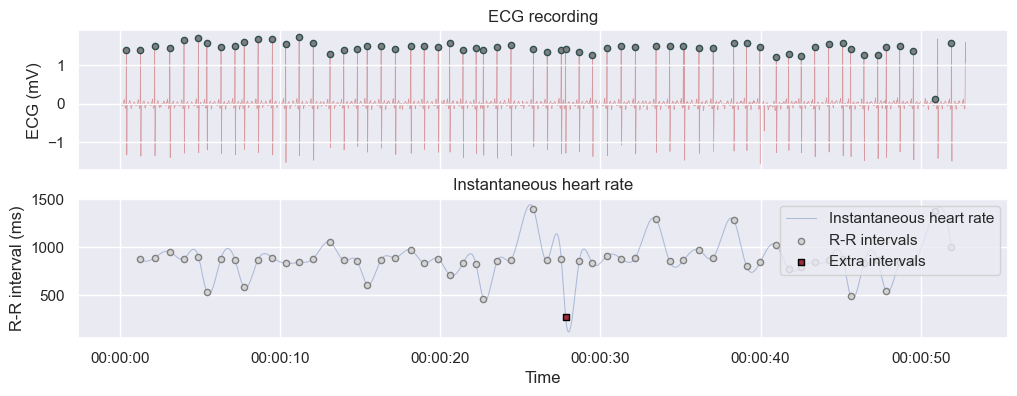

In [ ]:
"""
data_test = mergedDFClean.loc[(mergedDFClean['startTrial'] == 1)& (mergedDFClean['screamOn'] == 1) & (mergedDFClean['infoOn'] == 1) ]
dataPart = data_test.loc[data_test['partNum']==132].copy()
my_data = dataPart.EKG.values

import pandas as pd
import numpy as np
from systole.plots import plot_raw
%matplotlib inline

# 1) extract your raw EKG values and sample rate
signal4 = dataPart['EKG'].values     # 1D numpy array of mV values
sfreq  = 100                       # samples per second

# 2) build a time axis (in seconds)
time = np.arange(len(signal4)) / sfreq

# 3) pack into a pandas DataFrame with exactly the columns `time` and `ecg`
physio_df = pd.DataFrame({
    'time': time,
    'ecg':  signal4
})

# 4) (optional) slice out a window, e.g. seconds 60–90
ecg_segment = physio_df.ecg

# 5) now call plot_raw exactly as in the example
plot_raw(
    ecg_segment,
    modality="ecg",
    sfreq=sfreq,
    detector="sleepecg",
    backend="matplotlib",
    show_heart_rate=True,
    show_artefacts=True,
    figsize=(12,4)
);
plt.show()
"""

In [45]:
baseline_IBI= IBI_baseline(mergedDFClean.loc[(mergedDFClean['startTrial'] == 1)& (mergedDFClean['screamOn'] == 1) & (mergedDFClean['infoOn'] == 1) ])

In [46]:
baseline_IBI['baseline']

0       0.593333
1       0.616667
2       0.736667
3       0.715000
4       0.693333
          ...   
1363    0.780000
1364    0.875000
1365    0.845000
1366    0.845000
1367    0.865000
Name: baseline, Length: 1368, dtype: float64

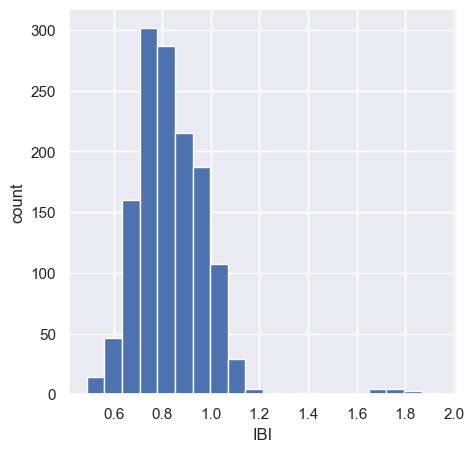

In [47]:
bins = 20
plt.hist(baseline_IBI.baseline.values, bins = bins)
plt.xlabel('IBI')
plt.ylabel('count')
plt.show()

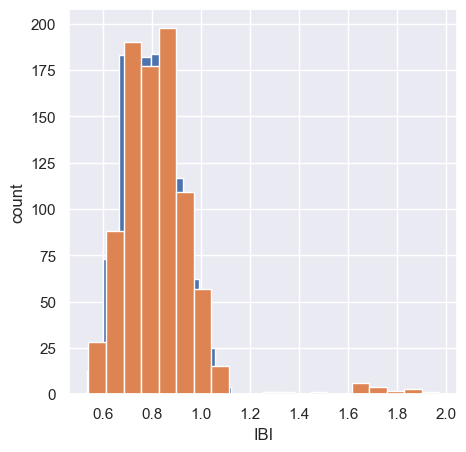

In [48]:
screamInfo_IBI= IBI_baseline(mergedDFClean.loc[((mergedDFClean['stimInfo'] == 1) | (mergedDFClean['stimNoInfo'] == 1)) & (mergedDFClean['screamOn'] == 1) & (mergedDFClean['infoOn'] == 0) ])
noScreamInfo_IBI= IBI_baseline(mergedDFClean.loc[((mergedDFClean['stimInfo'] == 1) | (mergedDFClean['stimNoInfo'] == 1)) & (mergedDFClean['screamOn'] == 0) & (mergedDFClean['infoOn'] == 0) ])

plt.hist(screamInfo_IBI.baseline.values,bins)
plt.hist(noScreamInfo_IBI.baseline.values,bins)

plt.xlabel('IBI')
plt.ylabel('count')
plt.show()


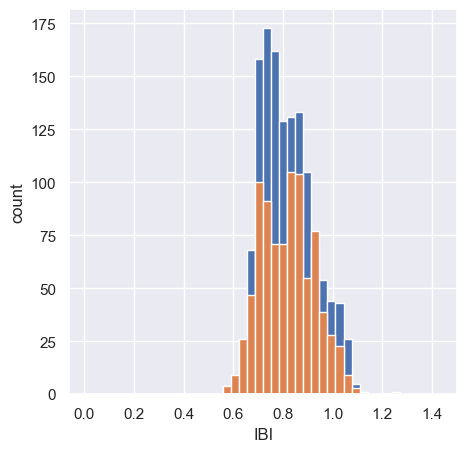

In [67]:
screamInfo_IBI= IBI_baseline(mergedDFClean.loc[ (mergedDFClean['screamOn'] == 0) & (mergedDFClean['infoOn'] == 1) ])
noScreamInfo_IBI= IBI_baseline(mergedDFClean.loc[ (mergedDFClean['screamOn'] == 0) & (mergedDFClean['infoOn'] == 0) ])

plt.hist(screamInfo_IBI.baseline.values, bins)

plt.hist(noScreamInfo_IBI.baseline.values,bins)
plt.xlim(right = 1.5)
plt.xlabel('IBI')
plt.ylabel('count')
plt.show()


In [63]:
selectON = noScreamInfo_IBI.loc[noScreamInfo_IBI["baseline"] < 0.6].participant.unique()

In [64]:
selectOFF = noScreamInfo_IBI.loc[noScreamInfo_IBI["baseline"] > 0.55].participant.unique()

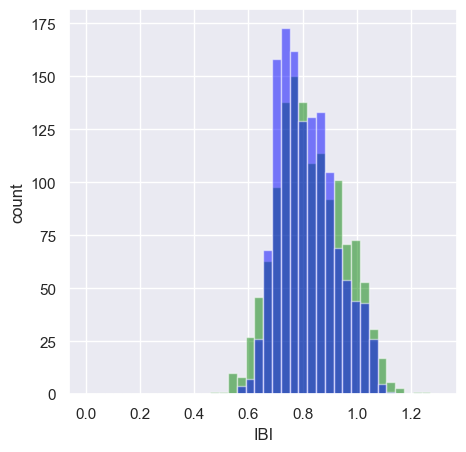

In [65]:
a=np.random.random(100)*0.5 #a uniform distribution
b=1-np.random.normal(size=100)*0.1 #a normal distribution 
bins=np.histogram(np.hstack((a,b)), bins=40)[1] #get the bin edges
plt.hist(baseline_IBI.baseline.values, bins , alpha=0.5, color =  "green")
plt.hist(screamInfo_IBI.baseline.values, bins, alpha=0.5,color =  "blue")


plt.xlabel('IBI')
plt.ylabel('count')
plt.show()


In [32]:
screamInfo_IBI

,participant,session,trial,baseline,PART_trial
0,44,0,0,0.570816,44_0_0
1,44,0,1,0.577097,44_0_1
2,44,0,5,0.573333,44_0_5
3,44,0,8,0.593810,44_0_8
4,44,0,9,0.550937,44_0_9
...,...,...,...,...,...
1346,132,4,17,0.668462,132_4_17
1347,132,4,19,0.532207,132_4_19
1348,132,5,2,0.507143,132_5_2
1349,132,5,6,0.707200,132_5_6


In [33]:
noScreamInfo_IBI

,participant,session,trial,baseline,PART_trial
0,44,0,11,0.562800,44_0_11
1,44,0,18,0.555806,44_0_18
2,44,1,5,0.647037,44_1_5
3,44,1,6,0.636667,44_1_6
4,44,1,7,0.649259,44_1_7
...,...,...,...,...,...
881,132,4,3,0.474286,132_4_3
882,132,4,4,0.480526,132_4_4
883,132,4,10,0.538889,132_4_10
884,132,4,13,0.582000,132_4_13


In [34]:
mergedDFClean.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename'],
      dtype='object')

In [52]:
processed_all = preprocess(mergedDFClean)
# Create a unique identifier by concatenating 'PART' and 'trials' columns
processed_all['PART_trial'] = processed_all['partNum'].astype(str) +'_' + processed_all['session'].astype(str) + '_'+ processed_all['trials'].astype(str)


In [53]:

# Filter the trials where 'scream' column is 1
trialNum_scream = processed_all.loc[processed_all['scream'] == 1, 'PART_trial'].unique()
trialNum_noScream = processed_all.loc[processed_all['noScream'] == 1, 'PART_trial'].unique()


# Filter the DataFrame based on each unique trial number and 'stimInfo' column
#this is wrong because it will also include trials where there's no info but during infochoice time
processed_stimInfo_scream = processed_all[(processed_all['PART_trial'].isin(trialNum_scream)) & (processed_all['stimInfo'] == 1)] 
processed_stimInfo_noScream = processed_all[(processed_all['PART_trial'].isin(trialNum_noScream)) & (processed_all['stimInfo'] == 1) ]

# Filter the trials in scream and no scream conditions, where 'stimInfo' is 1
trialNum_screamInfo = processed_stimInfo_scream['PART_trial'].unique()
trialNum_noScreamInfo = processed_stimInfo_noScream['PART_trial'].unique()

In [55]:
processed_all

,PART_x,EKG,EDA,startBlock,startTrial,infoChoice,stimInfo,stimNoInfo,scream,noScream,...,PART_y,delay_time,choice_keys,prob,screamOn,infoOn,filename,pEKG,peak,PART_trial
0,P044_Aversive,-0.126495,3.59192,0,1,0,0,0,0,0,...,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,-0.001979,False,44_0_0
1,P044_Aversive,-0.215912,3.59039,0,1,0,0,0,0,0,...,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,-0.079151,False,44_0_0
2,P044_Aversive,-0.307312,3.59192,0,1,0,0,0,0,0,...,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,-0.128269,False,44_0_0
3,P044_Aversive,-0.311432,3.59039,0,1,0,0,0,0,0,...,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,-0.122829,False,44_0_0
4,P044_Aversive,-0.287170,3.59192,0,1,0,0,0,0,0,...,AV_P044,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,-0.071119,False,44_0_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12708414,P132_Aversive,-0.005310,4.98199,0,0,0,0,0,0,0,...,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,0.033649,False,132_5_19
12708415,P132_Aversive,-0.020203,4.98810,0,0,0,0,0,0,0,...,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,0.031023,False,132_5_19
12708416,P132_Aversive,-0.015320,4.98352,0,0,0,0,0,0,0,...,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,0.025907,False,132_5_19
12708417,P132_Aversive,-0.010315,4.98199,0,0,0,0,0,0,0,...,AV_P132,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,0.018301,False,132_5_19


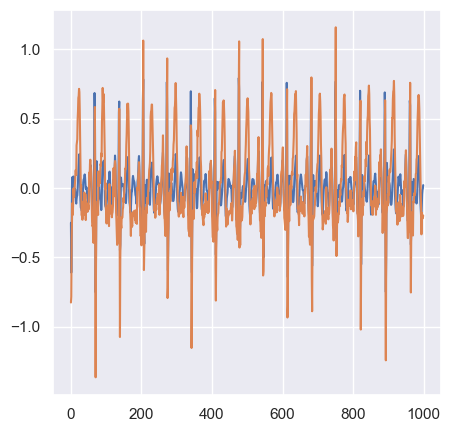

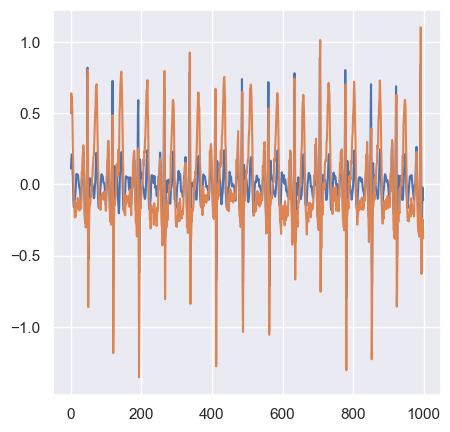

In [56]:
plt.plot(processed_all.pEKG.values[1000:2000])
plt.plot(processed_all.EKG.values[1000:2000])

plt.show()

plt.plot(processed_all.pEKG.values[15000:16000])
plt.plot(processed_all.EKG.values[15000:16000])

plt.show()



In [ ]:
trialNum_screamInfo

array(['3_0_2', '3_0_10', '3_0_16', '3_1_4', '3_1_9', '3_1_16', '3_1_19',
       '3_2_3', '3_2_5', '3_2_11', '3_2_14', '3_2_15', '3_3_8', '3_3_18',
       '3_4_2', '3_4_6', '3_4_7', '3_4_19', '3_5_1', '3_5_16', '5_0_0',
       '5_0_5', '5_0_10', '5_0_18', '5_1_2', '5_1_3', '5_1_5', '5_1_14',
       '5_1_16', '5_1_17', '7_0_1', '7_0_2', '7_0_3', '7_0_5', '7_0_7',
       '7_0_11', '7_0_12', '7_0_13', '7_0_16', '7_0_17', '7_0_19',
       '7_1_2', '7_1_6', '7_1_7', '7_1_9', '7_1_10', '7_1_11', '7_1_12',
       '7_1_13', '7_1_16', '7_2_1', '7_2_2', '7_2_5', '7_2_6', '7_2_9',
       '7_2_13', '7_2_14', '7_2_16', '7_2_17', '7_2_18', '10_0_15',
       '10_0_17', '10_1_2', '10_1_3', '10_1_8', '10_2_3', '10_2_11',
       '10_2_13', '10_2_15', '10_3_0', '10_3_5', '10_3_6', '10_3_14',
       '10_3_16', '10_3_19', '10_4_3', '10_4_8', '10_4_16', '10_5_0',
       '10_5_4', '10_5_7', '10_5_16', '13_0_0', '13_0_3', '13_0_6',
       '13_0_10', '13_0_11', '13_0_15', '13_0_16', '13_0_17', '13_1_3',
      

In [57]:

# extract data that includes both infoChoice and stimInfo
processed_stimInfo_scream = processed_all[(processed_all['PART_trial'].isin(trialNum_screamInfo)) & ((processed_all['stimInfo'] == 1) | (processed_all['infoChoice'] == 1))] 
processed_stimInfo_noScream = processed_all[(processed_all['PART_trial'].isin(trialNum_noScreamInfo)) & ((processed_all['stimInfo'] == 1) | (processed_all['infoChoice'] == 1))] 

In [58]:
processed_all.loc[(processed_all['partNum']==58)].trials.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [59]:
processed_all.loc[(processed_all['partNum']==58) & (processed_all['session']==4) & (processed_all['trials']==13)].stimNoInfo.unique()

array([0])

In [60]:
processed_stimInfo_scream = processed_all[(processed_all['PART_trial'].isin(trialNum_screamInfo)) & ((processed_all['stimInfo'] == 1) | (processed_all['infoChoice'] == 1))] 
processed_stimInfo_noScream = processed_all[(processed_all['PART_trial'].isin(trialNum_noScreamInfo)) & ((processed_all['stimInfo'] == 1) | (processed_all['infoChoice'] == 1))] 

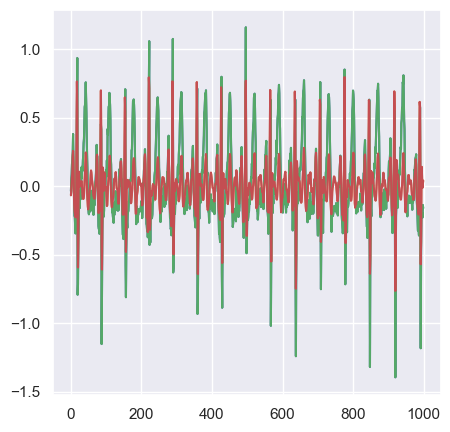

In [62]:
plt.plot(processed_stimInfo_noScream.EKG.values[1000:2000])
plt.plot(processed_stimInfo_noScream.pEKG.values[1000:2000])
plt.show()



In [ ]:
processed_stimInfo_scream

,Unnamed: 0,PART_x,EKG,EDA,startBlock,startTrial,infoChoice,stimInfo,stimNoInfo,scream,...,partNum,PART_y,delay_time,choice_keys,prob,screamOn,infoOn,filename,pEKG,PART_trial
4811,4811,P003,-0.312347,15.89810,0,0,1,0,0,0,...,3,AV_P003,10.0,j,3.0,1.0,1.0,AV_P003_timeline_Blocks_macVer_2023-03-21_15h3...,-0.098793,3_0_2
4812,4812,P003,-0.103302,15.89660,0,0,1,0,0,0,...,3,AV_P003,10.0,j,3.0,1.0,1.0,AV_P003_timeline_Blocks_macVer_2023-03-21_15h3...,-0.090291,3_0_2
4813,4813,P003,0.307312,15.89810,0,0,1,0,0,0,...,3,AV_P003,10.0,j,3.0,1.0,1.0,AV_P003_timeline_Blocks_macVer_2023-03-21_15h3...,-0.079033,3_0_2
4814,4814,P003,1.325070,15.89660,0,0,1,0,0,0,...,3,AV_P003,10.0,j,3.0,1.0,1.0,AV_P003_timeline_Blocks_macVer_2023-03-21_15h3...,-0.068153,3_0_2
4815,4815,P003,1.781160,15.89970,0,0,1,0,0,0,...,3,AV_P003,10.0,j,3.0,1.0,1.0,AV_P003_timeline_Blocks_macVer_2023-03-21_15h3...,-0.054574,3_0_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499703,6499703,P082_Aversive,-0.261841,2.39105,0,0,0,1,0,0,...,82,AV_P082,2.0,l,3.0,1.0,1.0,AV_P082_timeline_Blocks_Extra_randKeyCue_macVe...,-0.352562,82_3_12
6499704,6499704,P082_Aversive,-0.276184,2.39105,0,0,0,1,0,0,...,82,AV_P082,2.0,l,3.0,1.0,1.0,AV_P082_timeline_Blocks_Extra_randKeyCue_macVe...,-0.312027,82_3_12
6499705,6499705,P082_Aversive,-0.239563,2.39258,0,0,0,1,0,0,...,82,AV_P082,2.0,l,3.0,1.0,1.0,AV_P082_timeline_Blocks_Extra_randKeyCue_macVe...,-0.273389,82_3_12
6499706,6499706,P082_Aversive,-0.251007,2.39258,0,0,0,1,0,0,...,82,AV_P082,2.0,l,3.0,1.0,1.0,AV_P082_timeline_Blocks_Extra_randKeyCue_macVe...,-0.238832,82_3_12


In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

info_scream_IBI = stimInfo_avgIBI(stimInfo_IBI(processed_stimInfo_scream))
info_noScream_IBI = stimInfo_avgIBI(stimInfo_IBI(processed_stimInfo_noScream))

warnings.filterwarnings("default")

ValueError: All arrays must be of the same length

range(-2, 2)
range(-2, 2)


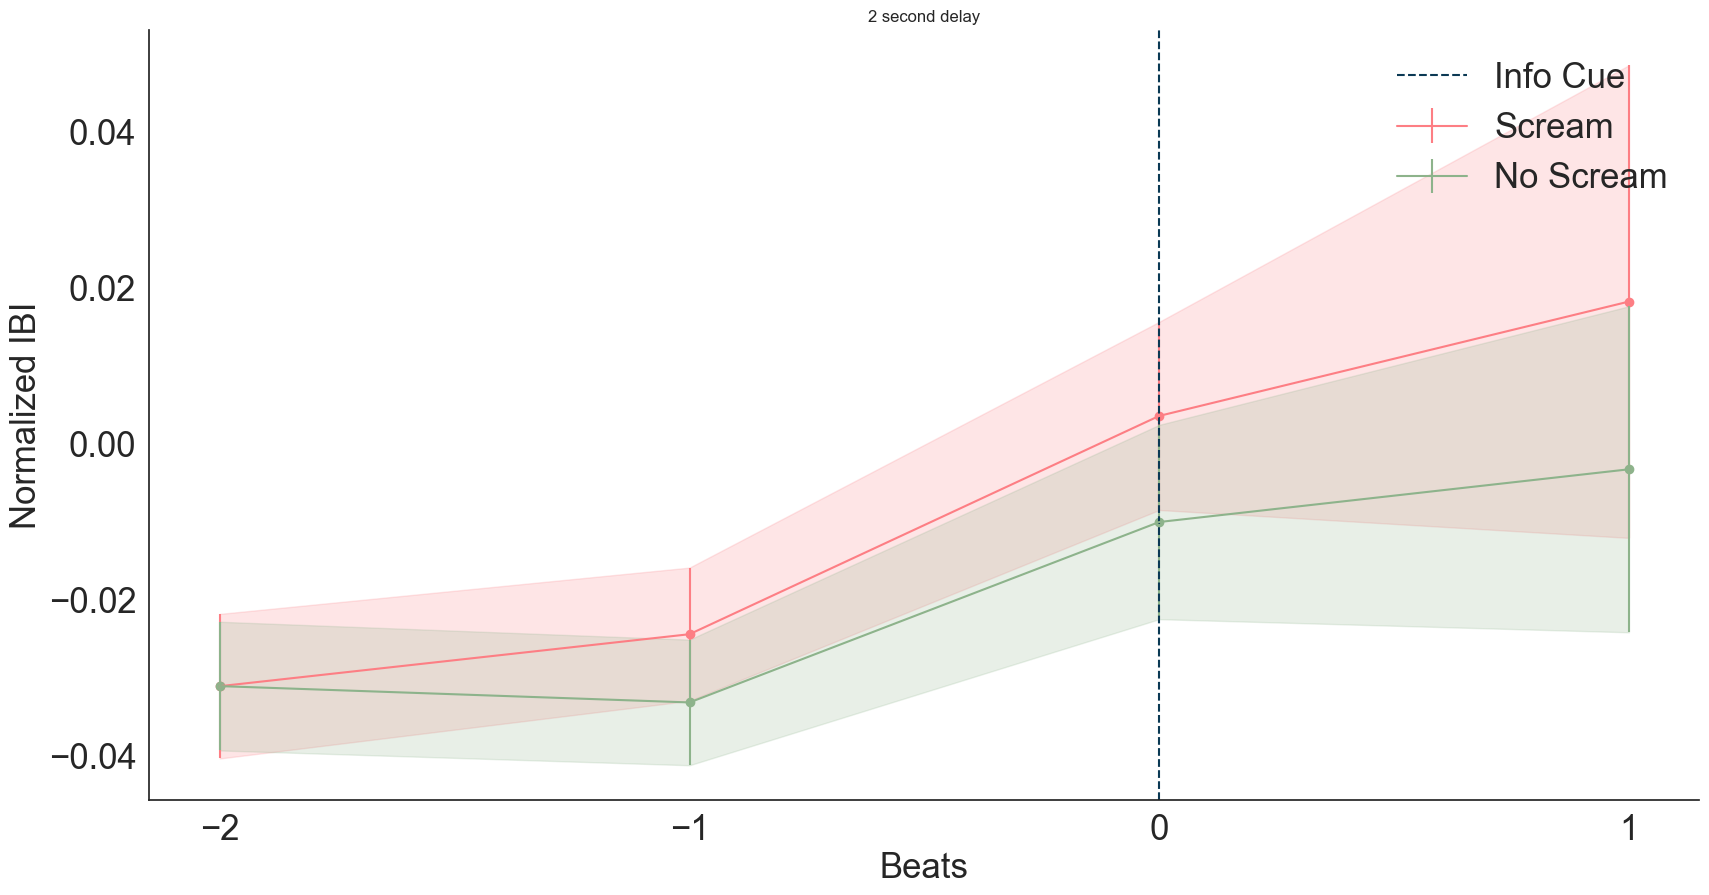

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,2)


range(-2, 5)
range(-2, 5)


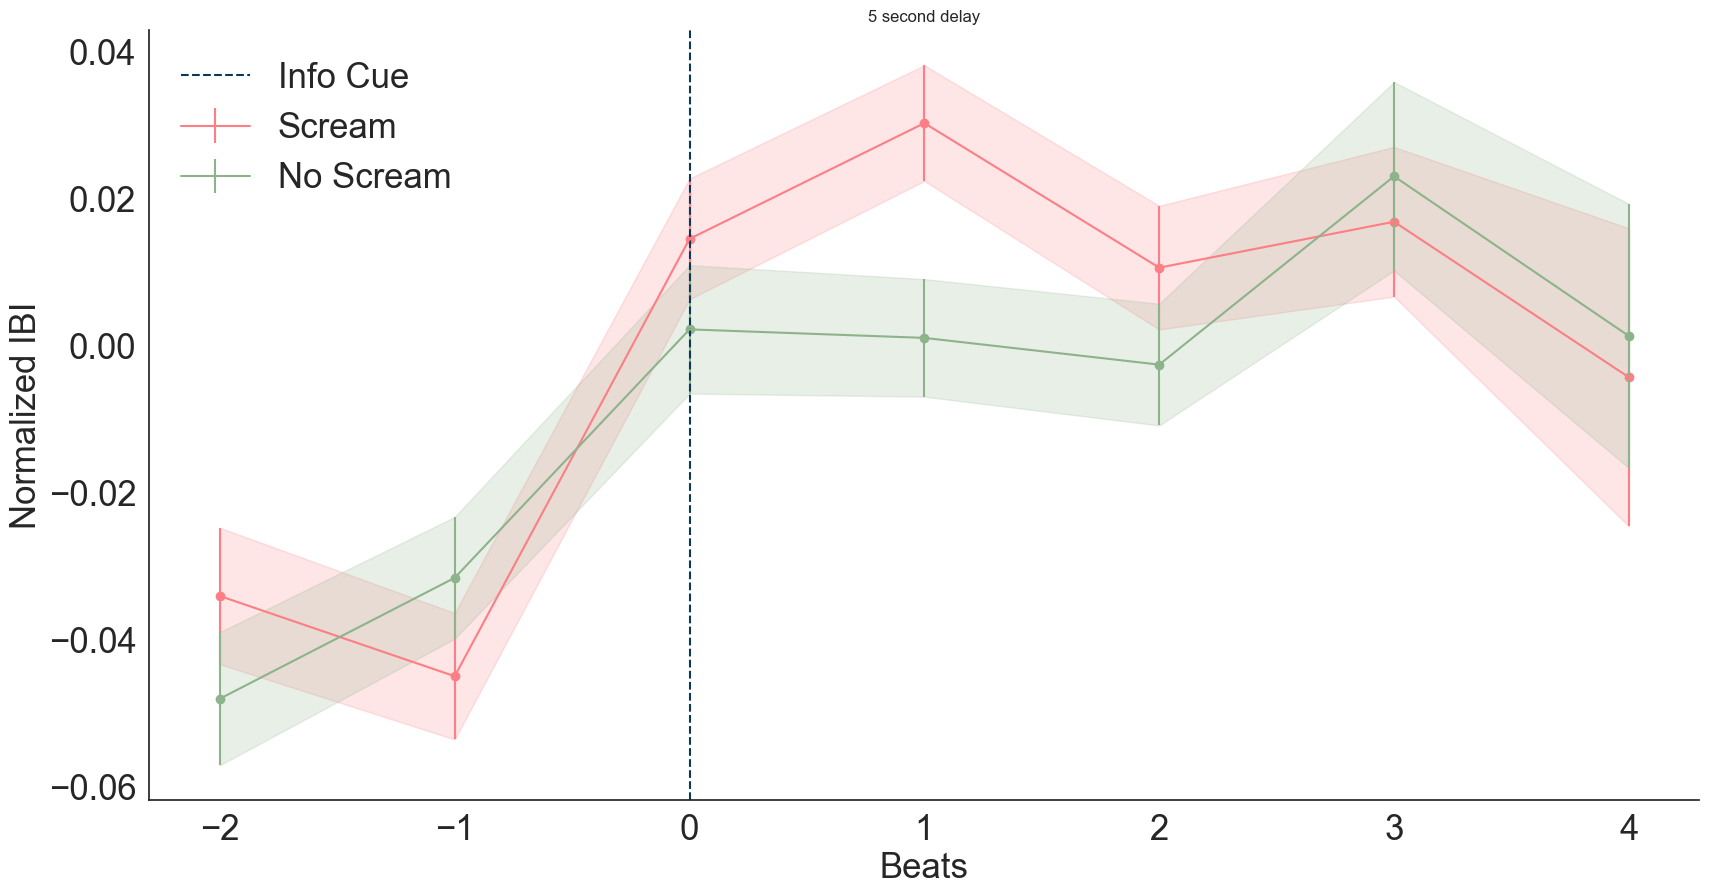

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,5)


range(-2, 11)
range(-2, 12)


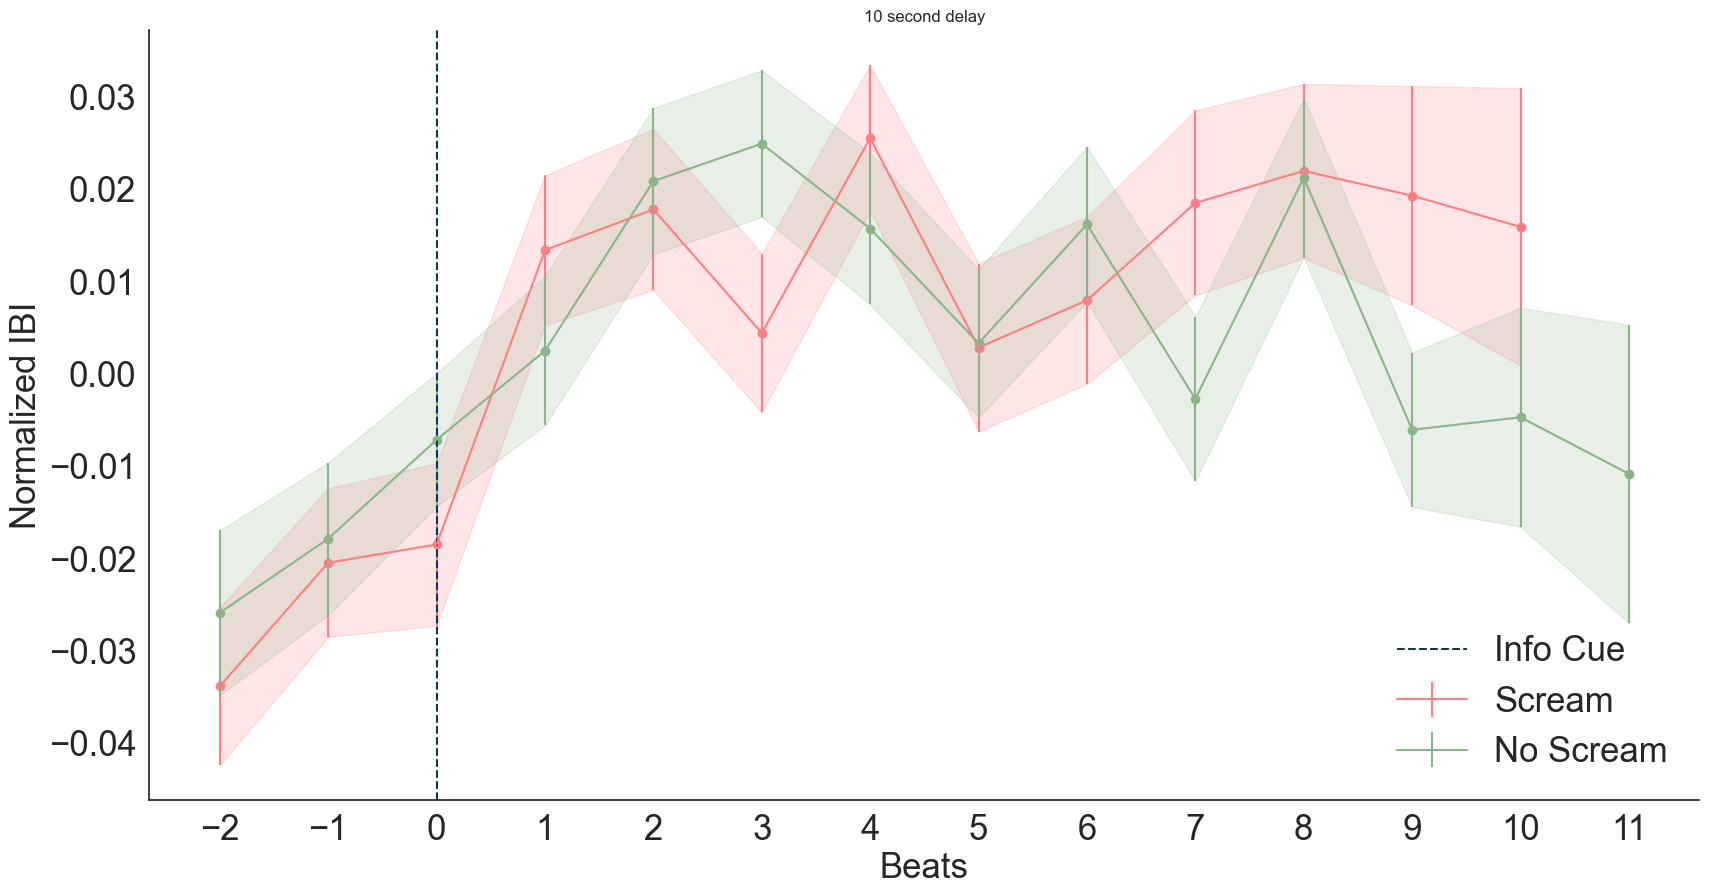

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,10)


range(-2, 25, 2)
range(-2, 26, 2)


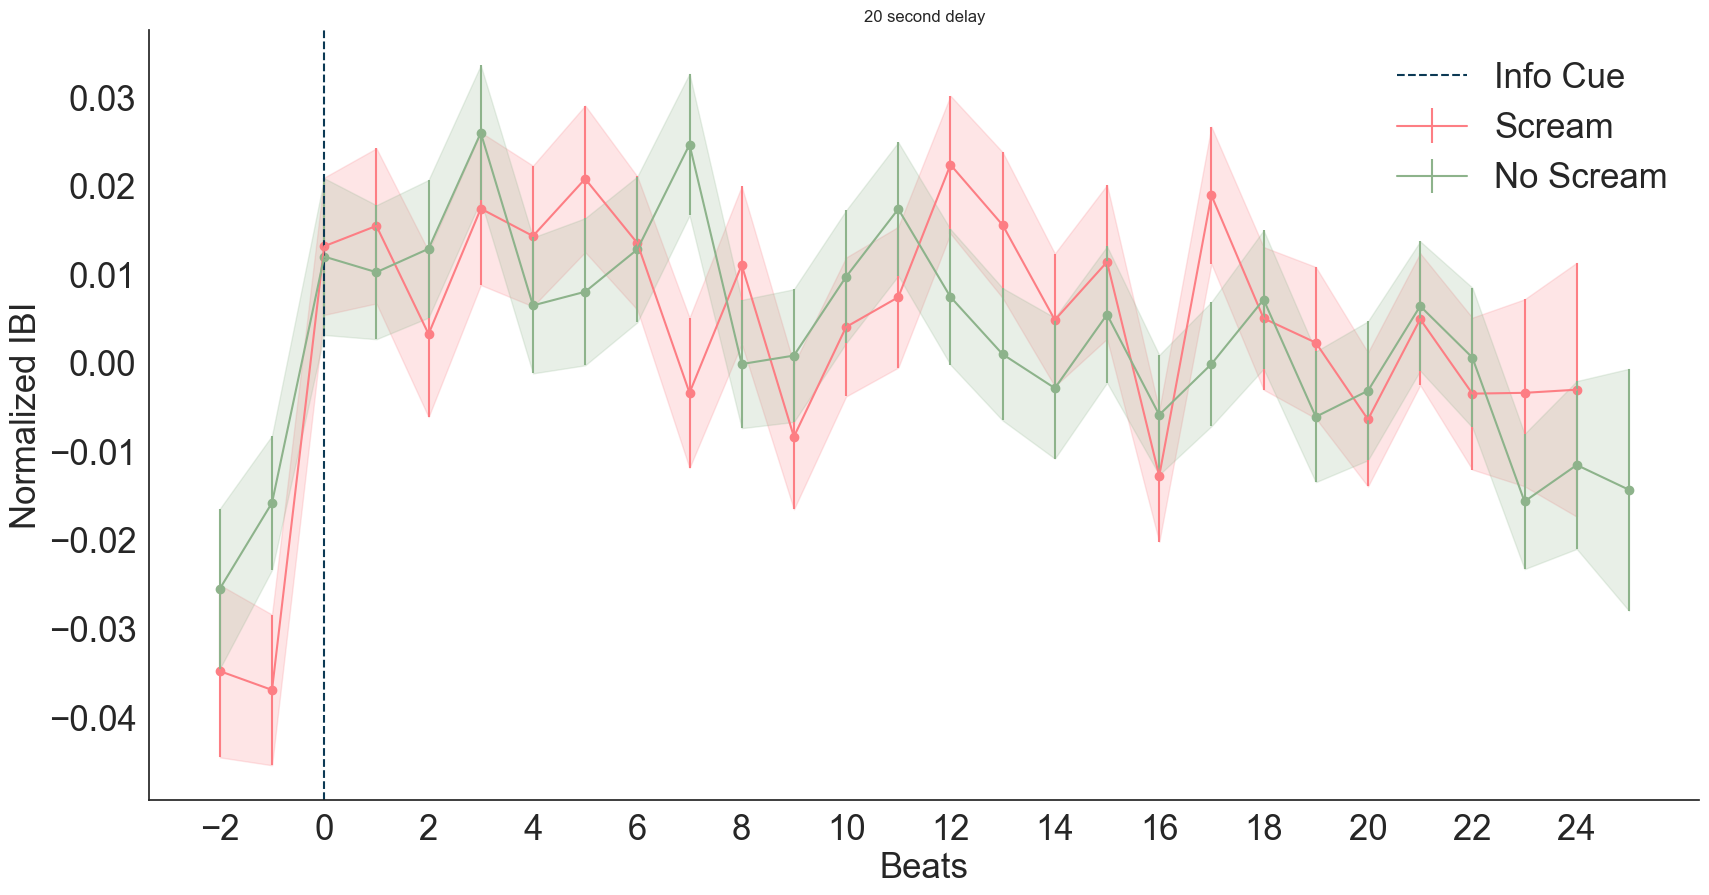

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,20)

range(-2, 52, 2)
range(-2, 53, 2)


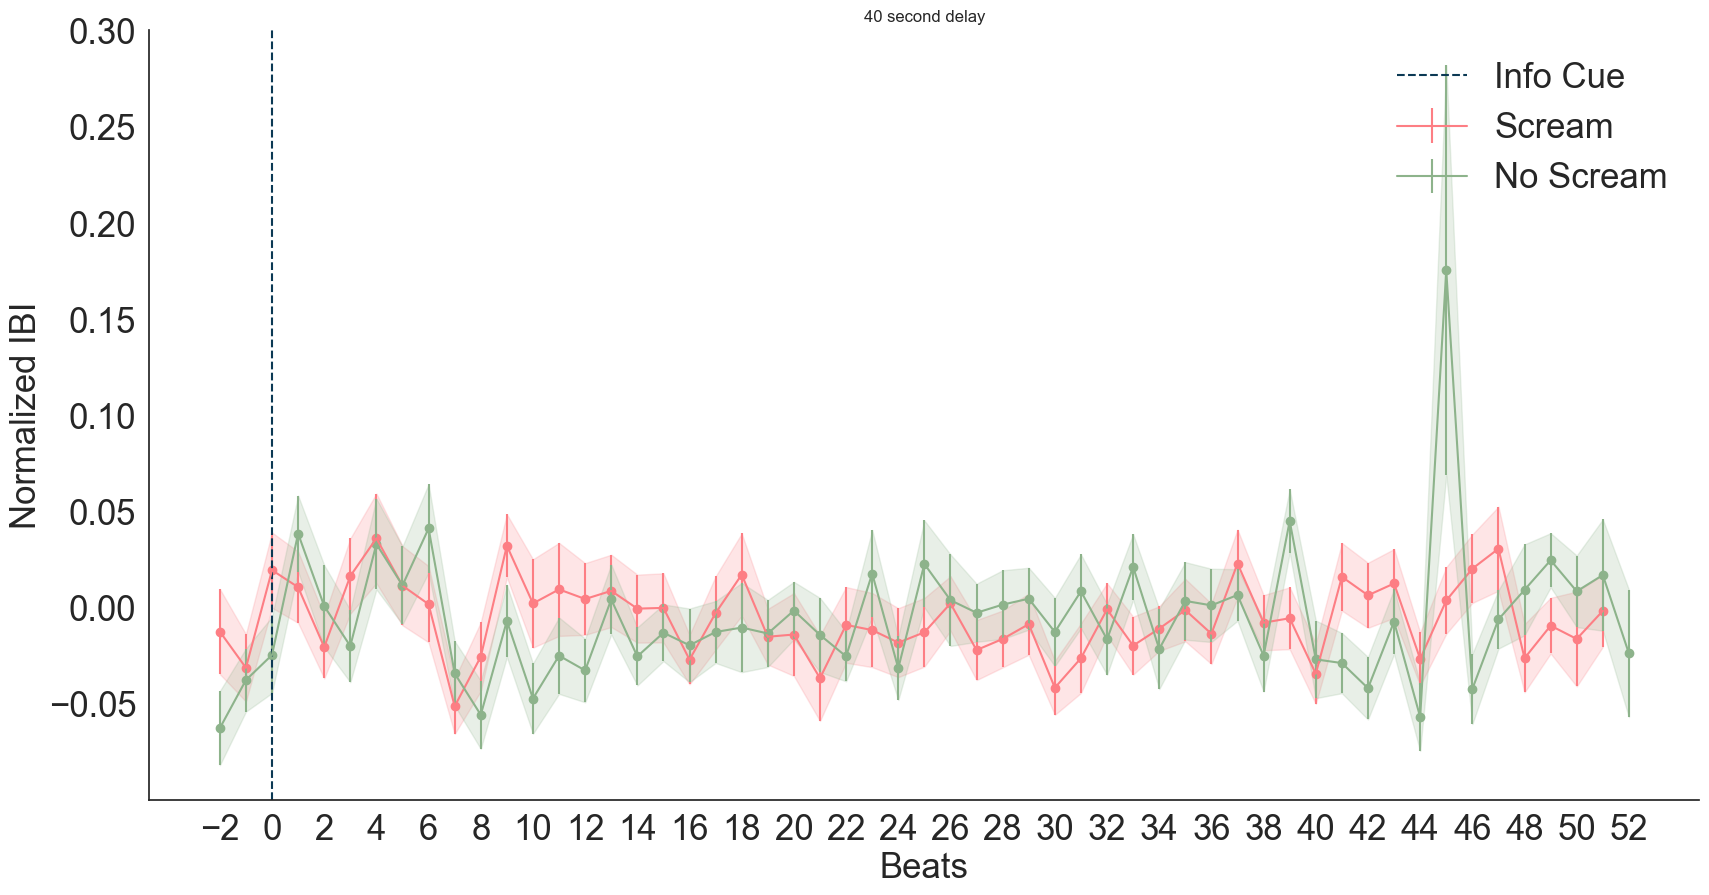

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,40)